__Note__: 
- Running this notebook requires downloading and extracting the audio- and state data via _aircraft_detector/Notebooks/Data Acquisition.ipynb_
<br><br>

Although the audio waveform of the MAV noise is too messy to predict, a time-frequency representation does allow prediction. Extracting these features is done using the __FeatureExtraction__ class, which requires a root directory and, optionally, non-default feature parameters. Note that the spectral features must be identical to the ones used for the aircraft classification (_aircraft_detector/Notebooks/Aircraft Classification/Feature Extraction.ipynb_).<br><br>



In [1]:
import os

import aircraft_detector.ego_noise_prediction.feature_extraction as fe


# assign root directory
root_directory = os.path.join(os.pardir, os.pardir, os.pardir, 'Data')
# settings for feature extraction
spectrum_settings = {
    'feature': 'Mel',  # default = 'Stft'
    'fft_sample_rate': 44100,  # default
    'stft_window_length': 1024,  # default
    'stft_hop_length': 512,  # default
    'frequency_bins': 60,  # default
}

In [2]:
import aircraft_detector.ego_noise_prediction.feature_extraction as fe


# load feature extractor class with directory and feature settings
extractor = fe.FeatureExtraction(root_directory, spectrum_settings)

/home/mark/anaconda3/envs/thesis/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/mark/anaconda3/envs/thesis/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


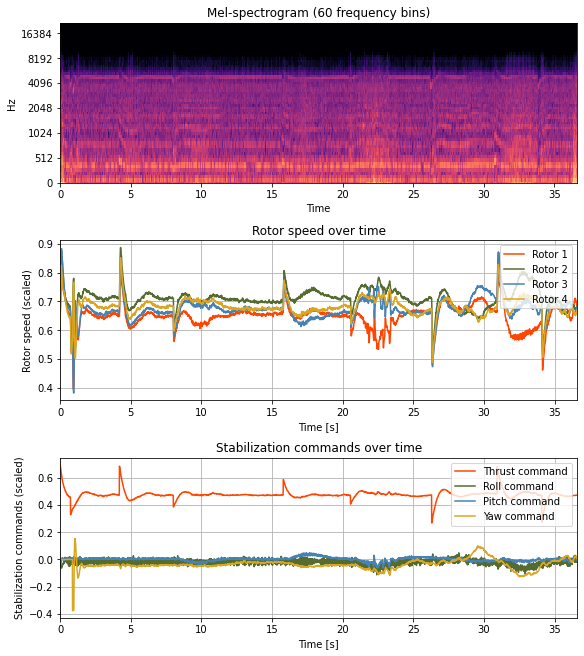

In [4]:
# extract the spectra from the audio
extractor.extract_spectra()

# augment and scale the states
extractor.extract_states()

# synchronize the spectra and states, then plot an example
extractor.synchronize_data()
fig = extractor.plot_features('Test', states=['rpm', 'cmd'])  # default: all states are plotted

Predicting and exporting the ego-noise spectra and exporting the model is done with the __EgoNoisePredictor__ class. This class requires a root directory and spectrum settings (identical to those above), and state settings (state IDs and model context). The __model context__ determines how many previous states the model should take into account (default: 0, i.e. sequence length = 1). <br><br>

The network used is a __recurrent neural network__, with two GRU layers and two fully-connected layers, and a model context of 6 (obtained through optimization in _Bayesian Optimization.ipynb_). Network configuration and training settings are passed to the class through dictionaries containing the appropriate _torch.nn_ attributes.<br><br>

In [12]:
import aircraft_detector.ego_noise_prediction.prediction as enp

# settings for states
states_settings = {
    'states': ['rpm', 'rpm_delta', 'cmd', 'cmd_delta', 'height', 'vel', 'acc', 'angles', 'rates'],
    'context_frames': 6  # default: 0
}

# load predictor class
predictor = enp.EgoNoisePredictor(root_directory, spectrum_settings, states_settings)
predictor.verbose = True  # print general stuff (default: True)
predictor.super_verbose = True  # print every epoch (default: False)

# load the training, validation and test data (and add model context)
predictor.load_datasets()

In [13]:
"""
Set the model configuration (list of layers):
    The first entry {'layer_type': 'GRU', 'hidden_size': 120} is equivalent to 
    torch.nn.GRU(input_size=189, hidden_size=120); input_size is derived from the dataset.
    From thereon, input_size or in_features is derived from the previous layer.
    By default, a linear output layer is added at the end, i.e.:
        torch.nn.Linear(in_features=160, out_features=1).
"""
model_config = [
    {'layer_type': 'GRU', 'hidden_size': 120}, 
    {'layer_type': 'GRU', 'hidden_size': 90},  # torch.nn.GRU(input_size=120, hidden_size=90)
    {'layer_type': 'Linear', 'out_features': 190},  # etc.
    {'layer_type': 'Linear', 'out_features': 160}
]
predictor.set_net_configuration(model_config)

# set the training configuration
# torch.optimizer.Adamw(lr=0.001, weight_decay=0.01, amsgrad=False)
optimizer = {'optimizer': 'AdamW', 'lr': 0.001, 'weight_decay': 0.01, 'amsgrad': False}
train_settings = {
    'epochs': 200, 
    'es_patience': 25,  # early stopping patience
    'batch_size': 256,
    'optimizer': optimizer,
}

Device: cuda.
Number of trainable parameters in network: 168390.
epoch 1: training loss = 0.011551, validation loss = 0.001886
Validation loss decreased (inf --> 0.001886).  Saving model ...
epoch 2: training loss = 0.001804, validation loss = 0.001844
Validation loss decreased (0.001886 --> 0.001844).  Saving model ...
epoch 3: training loss = 0.001787, validation loss = 0.001832
Validation loss decreased (0.001844 --> 0.001832).  Saving model ...
epoch 4: training loss = 0.001776, validation loss = 0.001816
Validation loss decreased (0.001832 --> 0.001816).  Saving model ...
epoch 5: training loss = 0.001762, validation loss = 0.001802
Validation loss decreased (0.001816 --> 0.001802).  Saving model ...
epoch 6: training loss = 0.001726, validation loss = 0.001768
Validation loss decreased (0.001802 --> 0.001768).  Saving model ...
epoch 7: training loss = 0.001695, validation loss = 0.001731
Validation loss decreased (0.001768 --> 0.001731).  Saving model ...
epoch 8: training loss 

epoch 62: training loss = 0.001345, validation loss = 0.001559
Validation loss increased (0.001486 --> 0.001559). Counter: 23 out of 25
epoch 63: training loss = 0.001340, validation loss = 0.001520
Validation loss increased (0.001486 --> 0.001520). Counter: 24 out of 25
epoch 64: training loss = 0.001335, validation loss = 0.001518
Validation loss increased (0.001486 --> 0.001518). Counter: 25 out of 25
Early stopping (using model at epoch 39 with val. loss 0.00149)


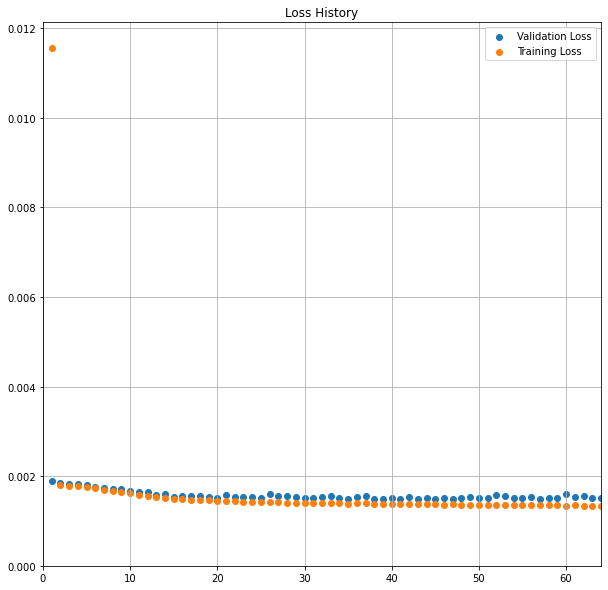

Training loss: 0.001385, Validation loss: 0.001486, Test loss: 0.001507.


In [15]:
from aircraft_detector.utils.plot_helper import plot_training_history

# train the model
model, training_losses, loss_history = predictor.train_network(train_settings)
train_loss, val_loss = training_losses

# plot training history
plot_training_history(loss_history)

# test the model
test_loss = predictor.test_network(model)
print("Training loss: %.6f, Validation loss: %.6f, Test loss: %.6f."
     % (train_loss, val_loss, test_loss))  # test loss should be around 1.507e-3

Network already exists.


/home/mark/anaconda3/envs/thesis/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/mark/anaconda3/envs/thesis/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


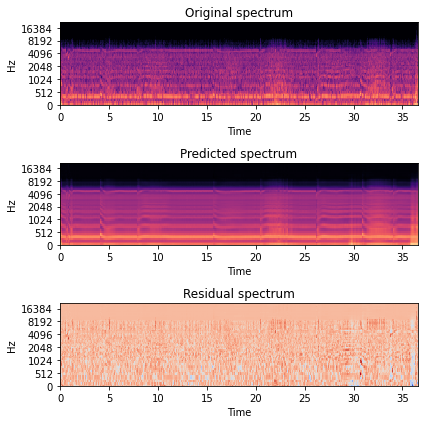

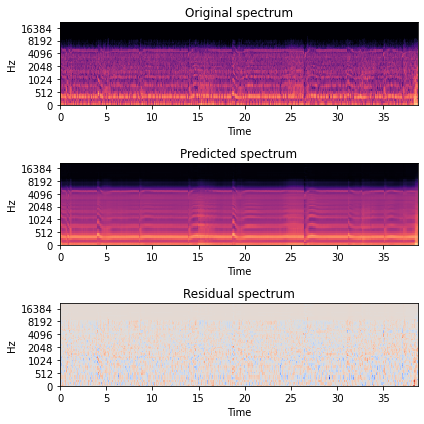

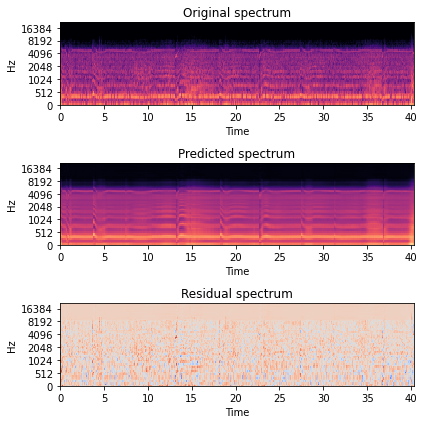

In [16]:
# save the model: model name dependent on test loss and model context
dir_model = predictor.save_network(model, test_loss)

# save the output (plot the test results)
predictor.save_network_output(model, dir_model, 'Train', plot=False)  # required for augmentation
predictor.save_network_output(model, dir_model, 'Val', plot=False)
predictor.save_network_output(model, dir_model, 'Test', plot=True)  # required for denoising